___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 


# TERCER EXAMEN PARCIAL
# SIMULACIÓN DE PROCESOS FINANCIEROS

## Nombre: Esteban Márquez Delgado

## Fecha: 28 de noviembre del 2021

## Por: Oscar David Jaramillo Z.

#### 1
Vamos a suponer que el curso de simulación de procesos financieros es una gran empresa de consultoría financiera que ofrece sus servicios a cualquier tipo de compañía o particular. Supongamos que acuden a nuestra empresa 4 personalidades con los siguientes problemas que desean solucionar:
> 1. El primer cliente, es un granjero que cultiva maíz y desea realizar una estrategia de cobertura que le permita prever las fluctuaciones en el precio de sus cultivos para el invierno entrante, en donde el pueda minimizar las pérdidas y maximizar las ganancias. 
> 2. La segunda empresa, es una empresa que construye productos en aluminio que tiene 1 año de estar ejerciendo en este tipo mercado. El gerente desea crear un plan de acción para expandir la empresa realizando estrategias financieras que le permitan maximizar sus ganancias y de esta forma cumplir con el objetivo planteado.
> 3. El tercer cliente, es una empresa joyera que fabrica sus piezas en oro. Esta empresa ha visto afectado sus ingresos debido a las fluctuaciones que ha presentado los últimos meses el precio del oro. Debido a esto, acude a nosotros para intentar mitigar estas fluctuaciones en el precio del oro, usando una adecuada estrategia financiera.
> 4. Nuestro último cliente, es la empresa mexicana PEMEX, que desea ejecutar ciertas estrategias financieras, que les permita cubrirse ante posibles caídas en el precio del barril del petróleo. Su objetivo en maximizar sus ganancias y minimizar las pérdidas de la compañía usando la mejor estrategia financiera (costo-beneficio).

Para cada uno de los clientes, se debe de presentar **3 posibles estrategias de cobertura usando opciones Europeas, Asiáticas y barrera tipo call ó put** . Además de ofrecer al cliente este abanico de posibilidades, ustedes como analistas financieros deben de recomendar la mejor estrategia costo-beneficio (basado en sus cálculos), que debería cada empresa tomar, para cumplir con su objetivo. Recuerden, pueden asumir diversos escenarios donde con la valuación realizada para cada una de sus opciones, puedan ustedes dar un estimado monetario en dos posibles escenarios. Por ejemplo, si pueden ejercer la opción entonces el cliente además de vender o comprar sus productos obtendrá una cantidad X de ganancias adicionales o en lugar de perder un 50% de los ingresos en sus ventas, el empresario puede perder sólo el 10% de los ingresos de sus ventas, por mencionar un posible escenario. Por el contrario, en el caso que no ejerza su opción el cliente tendrá una pérdida de la prima de la cantidad de opciones compradas (pero recalcando que el empresario puede estar cubierto ante diversas situaciones). La calificación será basada en el análisis que realicen y propongan a cada cliente usando los resultados de sus valuaciones.

**Para la valuación de opciones europeas debes de comparar tu valuación usando montecarlo con el valor teórico dado por el modelo de Black and Scholes dado en clase y concluir,**

> ###  Criterio de evaluación
> - Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.
> - **Ejercicio 1**: 40% La valuación de cada tipo de opción corresponderá al 40% de todo este examen.
> - **Ejercicio 2**: 60%. El restante 60% corresponderá a la decisión o recomendación basado en sus análisis que le recomendarán a cada compañía.

> ### Entrega
> Se debe de entregar un cuaderno de python donde se reporten todos los cálculos empleados en su análisis. La fecha límite de entrega será el martes 7 de diciembre a las 5 pm y se expondrá ese mismo día los resultados obtenidos.

> ### Suposiciones 
> - Deben de definirse correctamente el nombre de las acciones a descargar de Yahoo según la empresa asignada.
> - El examen es individual y códigos idénticos serán penalizados.


In [86]:
#Librerías utilizadas
from sklearn.neighbors import KernelDensity #Software machine learning library for kde
import pandas as pd #Librería extensión de numpy para el análisis y manejo de datos.
import pandas_datareader.data as web #Extracción de datos de la web en df.
import numpy as np #Soporte para operar con datos númericos, vectores y matrices.
import datetime #Módulos para trabajar con la fecha y el tiempo
from datetime import datetime, timedelta, date
import yfinance as yf #Librería que nos permite extraer información financiera de Yahoo
import scipy.stats as st #Librerías compuestas de algorítmicos matemáticos.
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt #Librería para la generación de gráficos de listas o arreglos.
import seaborn as sns #Librería de visualización basada en matplot
%matplotlib inline
#Opciones de visualización de dataframes
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6) 
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [87]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    """
    Retorna los precios de cierre ajustados de un activo financiero cuyo ticker es válido en la base de datos de Yahoo Finance.
    *tickers : Símbolos de los activos en cuestión.
    *start_date : Fecha de inicio para la descarga de precios
    *end_date : Fecha de fin para la descarga de precios (Último día hábil de no especificar: None)
    """
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

#Función que devuelve los retornos logarítmicos
def calc_daily_ret(closes):
    """
    Devuelve los retornos logarítmicos de los precios de cierre ajustados.
    *closes : Precios de cierre ajustados de activos.
    """
    return np.log(closes/closes.shift(1)).dropna()

#Función que devuelve la media y la desviación estándar de un dataset.
def mean_std(data):
    """
    Devuelve la media y desv. std de un dataset, idealmente rendimientos de activos.
    *data : Retornos del activo en cuestión.
    """
    media=round(data.mean(),6)
    desv=round(data.std(),6)
    return media,desv

def assets_plot(closes, color, titulo):
    """
    assets_plot grafica los precios historicos de un activo determinado y sus medias móviles
    de 50 y 100 días.
    *closes : Son los precios históricos.
    *color: Es el color del gráfico
    *titulo: Es el título del gráfico.
    """
    #Medias Móviles
    MA100 = closes.rolling(window=100).mean()
    MA50 = closes.rolling(window=50).mean()
    #Estética 
    plt.style.use('dark_background')
    plt.rc('grid', linestyle="--", color='gray')
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    
    #Gráfico
    closes.plot(ax=ax, label = 'Precios', color=color)
    MA100.plot(ax=ax, label = 'Media Movil 100')
    MA50.plot(ax=ax, label = 'Media Movil 50')
    plt.title(titulo)
    plt.grid(True)
    plt.legend(loc = "best")
    
def valor_esperado(S0, mu, sigma, expiracion, color):
    """
    Valor esperado devuelve los valores de los precios esperados de un activo según históricos
    y la media de 10000 simulaciones de posibles rendimientos para cada dia hábil o escenario.
    *S0 : Es el precio inicial.
    *mu : Son los rendimientos de los precios a una fecha determinada.
    *sigma : Es la desv. std de los rendimientos históricos.
    *expiración: Es la fecha hasta la cual se desea simular.
    *color: Es el color del gráfico.
    """
    #Longitud de fechas de hoy a la fecha determinada.
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start=today, end=expiracion, freq='B')
    ndays = len(dates)
    #Simulación de precios y rendimientos
    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,10000)+mu,index=dates)
    sim_closes = S0*np.exp(sim_ret.cumsum())
    Precio = sim_closes.mean(axis=1)
    ret = (sim_closes.T-Precio).T
    #Gráfico
    plt.rc('grid', linestyle="--", color='gray')
    Precio.plot(label= 'Valor Esperado', color=color)
    plt.grid(True)
    plt.legend(loc = "best")
    #Valores a tener en cuenta: inicial, esperado, incremento porcentual
    print('El Valor Actual de los contratos de Futuros es de:',round(S0,2))
    print('El Valor terminal esperado de los contratos de Futuros es de:', round(Precio[-1],2))
    print('Un incremento porcentual esperado de:', (((Precio[-1]-S0)/S0)*100).round(2),'%')
    
#Cálculo del precio de una opción europea.
def europea(K, S0, mu, sigma, expiracion, confianza, color_call, color_put, titulo, C):
    """
    Valuación de los precios esperados de los contratos europeos de 
    calls y puts en un plazo a una fecha de ej. y strike determinados.
    *K : Es el precio de ejercicio.
    *S0 : Es el precio actual e inicial para el cálculo.
    *mu : Son los rendimientos de los históricos.
    *sigma : Es la desv. std de los rendimientos históricos.
    *expiración: Es la fecha de expiracion del contrato.
    *color_call: Es el color del precio del call en el gráfico.
    *color_put: Es el color del precio del put en el gráfico.
    *titulo: Es el título del gráfico.
    *C: True o False para arrojar valor inicial y terminal con sus respectivos
    intervalos de confianza de calls(True) o puts(False).
    """
    #Cantidad de escenarios a simular y longitud de días
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start=today, end=expiracion, freq='B')
    ndays = len(dates)
    #Simulación de precios
    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,10000)+mu,index=dates)
    sim_closes = S0*np.exp(sim_ret.cumsum())
    #Cálculo de precios de calls y puts con precios simulados
    call=pd.DataFrame({'Prima_Call':np.exp(-mu*ndays)*np.fmax(sim_closes - K, 0).mean(axis=1)}, index=dates)
    put=pd.DataFrame({'Prima_Put':np.exp(-mu*ndays)*np.fmax(K - sim_closes, 0).mean(axis=1)}, index=dates)
    #Gráfico 
    plt.style.use('dark_background')
    plt.rc('grid', linestyle="--", color='gray')
    ax = call.plot(figsize=(10,5), color=color_call)
    put.plot(ax = ax, color=color_put)
    plt.title(titulo)
    plt.grid(True)
    #Intervalo de Confianza
    def intervalo_confianza(mean_est,sigma_est,n_confianza):
        return st.norm.interval(n_confianza, loc=mean_est, scale=sigma_est)
    
    if C==True:
                #Valor inicial del contrato call
                print('Valuación de Call Europeo en Fecha Actual',(round((call.iloc[0].Prima_Call),2)))
                print('Intervalo de confianza al',confianza*100,'%:',
                    [intervalo_confianza(call.iloc[0],sim_closes.iloc[0].sem(),confianza)[i][0] for i in range(0,2)])
                #Valor terminal del call con precios simulados del activo con su respectivo intervalo de confianza.
                print('Valuación de Call Europeo en Fecha de ej. con Precios Simulados:',(round((call.iloc[-1].Prima_Call),2)))
                print('Intervalo de confianza al',confianza*100,'%:',
                    [intervalo_confianza(call.iloc[-1],sim_closes.iloc[-1].sem(),confianza)[i][0] for i in range(0,2)])
    
    else:
        #Valor inicial del contrato put
        print('Valuación de Put Europeo en Fecha Actual:',(round((put.iloc[0].Prima_Put),2)))
        print('Intervalos de confianza al',confianza*100,'%:',
              [intervalo_confianza(put.iloc[0],sim_closes.iloc[0].sem(),confianza)[i][0] for i in range(0,2)])
        #Valor terminal del put con precios simulados del activo con su respectivo intervalo de confianza.
        print('Valuación de Put Europeo en Fecha de ej. con Precios Simulados:',(round((put.iloc[-1].Prima_Put),2)))
        print('Intervalos de confianza al',confianza*100,'%:',
              [intervalo_confianza(put.iloc[-1],sim_closes.iloc[-1].sem(),confianza)[i][0] for i in range(0,2)])
    
    
#Solución al cálculo del precio de calls y puts mediante la ec. de Black-Scholes
def BSprices(K, S0, mu, sigma, expiracion, color_call, color_put, titulo, C):
    """
    Solución a la ecuación de Black-Scholes para el cálculo del valor de los contratos
    calls y puts en un plazo a una fecha de ej. y strike.
    *K : Es el precio de ejercicio.
    *S0 : Es el precio actual e inicial para el cálculo.
    *mu : Son los rendimientos de los históricos.
    *sigma : Es la desv. std de los rendimientos históricos.
    *expiración: Es la fecha de ejercicio.
    """
    norm = lambda x:st.norm(0, 1).cdf(x) 
    #Cálculo de días restantes para expiracion o fecha de ej.
    today = pd.Timestamp(date.today()) # Datos de la opción y del día de actual
    dates = pd.date_range(start=today, end=expiry, freq='B') # Fechas desde el día de hoy hasta ej.
    ndays = len(dates) #Días para expiracion
    #Datos para el cálculo de ec. de Black-Scholes 
    def d1(T):
        return (np.log(S0/K) + (mu+(sigma**2)/2)*T) / (sigma*np.sqrt(T))
    def d2(T):
        return (np.log(S0/K) + (mu-(sigma**2)/2)*T) / (sigma*np.sqrt(T))
    def call (K, S0, mu, sigma, T):
        return S0*norm(d1(T)) - K*np.exp(-mu*T)*norm(d2(T))
    def put (K, S0, mu, sigma, T):
        return K*np.exp(-mu*T)*norm(-d2(T)) - S0*norm(-d1(T)) 
    #Solución a la ec. de Black-Scholes.
    call = pd.DataFrame({'Prima_Call:': [call(K, S0, mu, sigma, T) for T in np.arange(ndays)+1]}, index=dates)
    put = pd.DataFrame({'Prima_Put:': [put(K, S0, mu, sigma, T) for T in np.arange(ndays)+1]}, index=dates)
    #Gráfico 
    plt.style.use('dark_background')
    plt.rc('grid', linestyle="--", color='gray')
    ax = call.plot(figsize=(10,5), color=color_call)
    put.plot(ax = ax, color=color_put)
    plt.title(titulo)
    plt.grid(True)
    if C==True:
                #Valor inicial del contrato call
                print('Valuación de Call mediante Black-Scholes en Fecha Actual:',round((call.iloc[0][0]),2))
                #Valor terminal del call con precios simulados del activo con su respectivo intervalo de confianza.
                print('Valuación de Call mediante Black-Scholes en Fecha de ej.:',round((call.iloc[-1][0]),2))
    else:
        #Valor inicial del contrato put
        print('Valuación de Put mediante Black-Scholes en Fecha Actual:',round((put.iloc[0][0]),2))
        #Valor terminal del put con precios simulados del activo con su respectivo intervalo de confianza.
        print('Valuación de Put mediante Black-Scholes en Fecha de ej.:',round((put.iloc[-1][0]),2))
        
def asiatica(K,S0, mu, sigma, expiracion, color_call, color_put,titulo):
    #Cantidad de escenarios a simular y longitud de días
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start=today, end=expiracion, freq='B')
    ndays = len(dates)
    #Simulación de precios
    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,10000)+mu,index=dates)
    sim_closes = S0*np.exp(sim_ret.cumsum())
    #Cálculo de precios de calls y puts con precios simulados
    call=pd.DataFrame({'Prima_Call':np.exp(-mu*ndays)*np.fmax(sim_closes - K, 0).mean(axis=1)}, index=dates)
    put=pd.DataFrame({'Prima_Put':np.exp(-mu*ndays)*np.fmax(K - sim_closes, 0).mean(axis=1)}, index=dates)
    
    #Promedio aritmético para cálculo de opciones asiáticas
    promedios = 1/(np.arange(sim_closes.shape[0])+1) 
    acum = sim_closes.cumsum() 
    precios = np.multiply(promedios,acum.T).T
    #Cálculo de calls y puts asiáticos de promedio aritmético
    C_A = pd.DataFrame({'Call_Asiático':np.exp(-mu*ndays)*np.fmax(precios - K, 0).mean(axis=1)},
                       index=dates)
    P_A = pd.DataFrame({'Put_Asiático':np.exp(-mu*ndays)*np.fmax(K - precios, 0).mean(axis=1)},
                       index=dates)
    #Gráfico 
    plt.style.use('dark_background')
    plt.rc('grid', linestyle="--", color='gray')
    #Call
    ax = call.plot(figsize=(10,5), color=color_call)
    C_A.plot(ax = ax, linestyle='dashed')
    #Put
    put.plot(ax = ax, color=color_put)
    P_A.plot(ax = ax, linestyle='dashed')
    plt.title(titulo)
    plt.grid(True)
    
def barrera(K, S0, mu, sigma, expiracion, barrera_up, barrera_down, color_call, color_put, titulo):
    """
    Cálculo del precio de las posibles opciones barrera dada la valuación de los precios esperados
    de los contratos europeos y su barrera para la determinación del knock(in o out).
    *K : Es el precio de ejercicio.
    *S0 : Es el precio actual e inicial para el cálculo.
    *mu : Son los rendimientos de los históricos.
    *sigma : Es la desv. std de los rendimientos históricos.
    *expiración: Es la fecha de ejercicio.
    *barrera_up: Es la barrera por encima del valor esperado.
    *barrera_down: Es la barrera por debajo del spot.
    *color_call: Es el color del precio del call en el gráfico.
    *color_put: Es el color del precio del put en el gráfico.
    *titulo: Es el título del gráfico para calls o puts barrera.
    """
    #Cantidad de escenarios a simular y longitud de días
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start=today, end=expiracion, freq='B')
    ndays = len(dates)
    #Simulación de precios
    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,10000)+mu,index=dates)
    sim_closes = S0*np.exp(sim_ret.cumsum())
    #Cálculo de precios de calls y puts con precios simulados
    call=pd.DataFrame({'Prima_Call':np.exp(-mu*ndays)*np.fmax(sim_closes - K, 0).mean(axis=1)}, index=dates)
    put=pd.DataFrame({'Prima_Put':np.exp(-mu*ndays)*np.fmax(K - sim_closes, 0).mean(axis=1)}, index=dates)
    
    # Estética del gráfico de CALLS posibles
    plt.style.use('dark_background')
    plt.rc('grid', linestyle="--", color='gray')
    #Graficado del cálculo de calls con precios simulados durante el plazo.
    ax = call.plot(figsize=(10,5), color=color_call); 
    
    #Call Up and In
    I = (sim_closes > barrera_up).cumsum(axis=0) > 0
    CallUpIn = pd.DataFrame({'Call Up (Knock In)':np.exp(-mu*ndays)*\
                             (I * np.fmax(sim_closes - K, 0)).mean(axis=1)},index=dates)
    CallUpIn.plot(ax=ax,linestyle='dashed')
    plt.title(titulo+str(' Call'))
    #Call Down and in
    I = (sim_closes < barrera_down).cumsum(axis=0) > 0
    CallDownIn = pd.DataFrame({'Call Down (Knock In)':np.exp(-mu*ndays)*\
                               (I * np.fmax(sim_closes - K, 0)).mean(axis=1)},index=dates)    
    CallDownIn.plot(ax=ax,linestyle='dashed');
    #Call Up and Out
    I = (sim_closes > barrera_up).cumsum(axis=0) == 0
    CallUpOut = pd.DataFrame({'Call Up (Knock Out)':np.exp(-mu*ndays)*\
                              (I * np.fmax(sim_closes - K, 0)).mean(axis=1)},index=dates)
    CallUpOut.plot(ax=ax,linestyle='dashed');
    #Call Down and Out
    I = (sim_closes < barrera_down).cumsum(axis=0) == 0
    CallDownOut = pd.DataFrame({'Call Down (Knock Out)':np.exp(-mu*ndays)*\
                                (I * np.fmax(sim_closes - K, 0)).mean(axis=1)},index=dates)
    CallDownOut.plot(ax=ax,linestyle='dashed');
    plt.grid(True)
    
    
    # Estética del gráfico de PUTS posibles
    plt.rc('grid', linestyle="--", color='gray')
    ax = put.plot(figsize=(10,5), color=color_put);
    
    #Put Up and In
    I = (sim_closes > barrera_up).cumsum(axis=0) > 0
    PutUpIn = pd.DataFrame({'Put Up (Knock In)':np.exp(-mu*ndays)*\
                            (I * np.fmax(K - sim_closes, 0)).mean(axis=1)},index=dates)
    PutUpIn.plot(ax=ax,linestyle='dashed')
    plt.title(titulo+str(' Put'))
    #Put Down and in
    I = (sim_closes < barrera_down).cumsum(axis=0) > 0
    PutDownIn = pd.DataFrame({'Put Down (Knock In)':np.exp(-mu*ndays)*(I * np.fmax(K - sim_closes, 0))
                       .mean(axis=1)},index=dates)    
    PutDownIn.plot(ax=ax, linestyle='dashed');
    #Put Up and Out
    I = (sim_closes > barrera_up).cumsum(axis=0) == 0
    PutUpOut = pd.DataFrame({'Put Up (Knock Out)':np.exp(-mu*ndays)*(I * np.fmax(K - sim_closes, 0))
                       .mean(axis=1)},index=dates)
    PutUpOut.plot(ax=ax,linestyle='dashed');
    #Call Down and Out
    I = (sim_closes < barrera_down).cumsum(axis=0) == 0
    PutDownOut = pd.DataFrame({'Put Down (Knock Out)':np.exp(-mu*ndays)*(I * np.fmax(K - sim_closes, 0))
                       .mean(axis=1)},index=dates)
    PutDownOut.plot(ax=ax, linestyle='dashed');
    plt.grid(True)
    
def cobertura(K, S0, mu, sigma, expiracion, C, bins, color_SC, color_CC, barrera_down):
    """
    *K : Es el precio de ejercicio.
    *S0 : Es el precio actual e inicial para el cálculo.
    *mu : Son los rendimientos de los históricos.
    *sigma : Es la desv. std de los rendimientos históricos.
    *expiración: Es la fecha de expiracion del contrato.
    *C: Es la determinación del tipo de opción para el cálculo de los rendimientos (Call=True, Put=False) 
    *bins: Es el número de barras del histograma de retornos para las coberturas.
    *color_SC: Es el color de los histogramas de los retornos sin cobertura.
    *color_CC: Es el color de los histogramas de los retornos para las coberturas
    *barrera_down: Es la barrera por debajo del spot.
    
    """
    #Cantidad de escenarios a simular y longitud de días
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start=today, end=expiracion, freq='B')
    ndays = len(dates)
    #Simulación de precios y rendimientos (valor esperado)
    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,10000)+mu,index=dates)
    sim_closes = S0*np.exp(sim_ret.cumsum())
    Precio = sim_closes.mean(axis=1)
    ret = (sim_closes.T-Precio).T
    #Promedio aritmético para cálculo de opciones asiáticas
    promedios = 1/(np.arange(sim_closes.shape[0])+1) 
    acum = sim_closes.cumsum() 
    precios = np.multiply(promedios,acum.T).T
    ##########CALLS#########
    if C==True: #Retornos esperados sin y con cobertura de call europeo
                call=pd.DataFrame({'Prima_Call':np.exp(-mu*ndays)*np.fmax(sim_closes - K, 0)
                                 .mean(axis=1)}, index=dates)
                call_ret=(np.fmax(sim_closes,K).T - Precio - np.exp(mu*ndays)*call['Prima_Call']).T                
                plt.rc('grid', linestyle="--", color='gray')
                plt.figure(figsize=(10,5))
                ax = plt.hist(ret.iloc[-1], label='Retornos Esperados sin Cobertura:', bins=bins, alpha=0.7, color=color_SC)
                plt.hist(call_ret.iloc[-1], label='Ganancias Esperadas con Cobertura', bins=bins, alpha=0.7, color=color_CC)
                plt.legend()
                plt.grid(True)
                print('El Retorno esperado sin cobertura es de:', round(Precio[-1]-S0,2))
                print('Las Ganancias esperadas con cobertura de Call europeo es de:', round(call_ret.iloc[-1].mean(),2))
                
                #Retornos esperados de cobertura de call asiático con promedio aritmético
                C_A = pd.DataFrame({'Call_Asiático':np.exp(-mu*ndays)*np.fmax(precios - K, 0)
                                    .mean(axis=1)},index=dates)
                ret_CA = (np.fmax(precios,K).T - Precio - np.exp(mu*ndays)*C_A['Call_Asiático']).T
                plt.rc('grid', linestyle="--", color='gray')
                plt.figure(figsize=(10,5))
                ax = plt.hist(ret.iloc[-1], label='Retornos Esperados sin Cobertura:', bins=bins, alpha=0.7, color=color_SC)
                plt.hist(ret_CA.iloc[-1], label='Ganancias Esperadas con Cobertura', bins=bins, alpha=0.7, color=color_CC)
                plt.legend()
                plt.grid(True)
                
    ##########PUTS#########
    else: #Retornos esperados sin y con cobertura de put europeo
        put=pd.DataFrame({'Prima_Put':np.exp(-mu*ndays)*np.fmax(K - sim_closes, 0)
                          .mean(axis=1)}, index=dates)
        put_ret = (Precio - np.fmin(sim_closes,K).T - np.exp(mu*ndays)*put['Prima_Put']).T
        plt.figure(figsize=(10,5))
        plt.rc('grid', linestyle="--", color='gray')
        ax = plt.hist(ret.iloc[-1], label='Retornos Esperados sin Cobertura', bins=bins, alpha=0.7, color=color_SC)
        plt.hist(put_ret.iloc[-1], label='Ganancias Esperadas con Cobertura de Put Europeo', bins=bins, alpha=0.7, color=color_CC)
        plt.title('Retornos esperados de Put Europeo')
        plt.legend()
        plt.grid(True)
        print('El Retorno esperado sin cobertura es de:', round(Precio[-1]-S0,2))
        print('Las Ganancias esperadas con cobertura de Put europeo es de:', round(put_ret.iloc[-1].mean(),2))
        print('El valor máx. de las Ganancias con cobertura es:', round(put_ret.iloc[-1].max(),2))
        print('El valor min. de las Ganancias con cobertura es:', round(put_ret.iloc[-1].min(),2))
        
        #Retornos esperados de cobertura de put asiático con promedio aritmético
        P_A = pd.DataFrame({'Put_Asiatico':np.exp(-mu*ndays)*np.fmax(K - precios, 0).mean(axis=1)},
                           index=dates)
        ret_PA =  (Precio - np.fmin(precios,K).T - np.exp(mu*ndays)*P_A['Put_Asiatico']).T
        
        plt.rc('grid', linestyle="--", color='gray')
        plt.figure(figsize=(10,5))
        ax = plt.hist(ret.iloc[-1], label='Retornos Esperados sin Cobertura:', bins=bins, alpha=0.7, color=color_SC)
        plt.hist(ret_PA.iloc[-1], label='Ganancias Esperadas con Cobertura de Put Asiático', bins=bins, alpha=0.7, color=color_CC)
        plt.title('Retornos esperados de Put Asiático')
        plt.legend()
        plt.grid(True)
        plt.show()
        print('Las Ganancias esperadas con cobertura de Put asiático es de:', round(ret_PA.iloc[-1].mean(),2))
        print('El valor máx. de las Ganancias con cobertura es:', round(ret_PA.iloc[-1].max(),2))
        print('El valor min. de las Ganancias con cobertura es:', round(ret_PA.iloc[-1].min(),2))
        #Retornos esperados de cobertura de Put Down and In.
        I = (sim_closes < barrera_down).cumsum(axis=0) > 0
        PutDownIn = pd.DataFrame({'Put Down (Knock In)':np.exp(-mu*ndays)*(I * np.fmax(K - sim_closes, 0))
                       .mean(axis=1)},index=dates)    
        ret_PDI = (Precio - np.fmin(sim_closes,K)[I].T - np.exp(mu*ndays)*PutDownIn['Put Down (Knock In)']).T.fillna(method='ffill')
        ret_PDI_ = (Precio - sim_closes[~I].T - PutDownIn['Put Down (Knock In)']).T.fillna(method='ffill')
        ret_PutDI = ret_PDI + ret_PDI_
        
        plt.figure(figsize=(10,5))
        ax = plt.hist(ret.iloc[-1], label='Retornos Esperados sin Cobertura:', bins=bins, alpha=0.7, color=color_SC)
        plt.hist(ret_PutDI.iloc[-1], label='Ganancias Esperadas con Cobertura de put Barrera Down-and-In', bins=bins, alpha=0.7,color=color_CC)
        plt.title('Retornos esperados de Put Barrera Down and In')
        plt.legend()
        plt.grid(True)
        plt.show()
        print('Las Ganancias esperadas con cobertura de Put Barrera Down and In es de:', round(ret_PutDI.iloc[-1].mean(),2))
        print('El valor máx. de las Ganancias con cobertura es:', round(ret_PutDI.iloc[-1].max(),2))
        print('El valor min. de las Ganancias con cobertura es:', round(ret_PutDI.iloc[-1].min(),2))

Uno de los **supuestos** es que los **costos** se mantienen **constantes** y lo único que pudiera influenciar las **pérdidas o las ganancias** de los participantes del mercado para un activo es la **fluctuación de los precios y las estrategias** que el participante asume para lo cual los instrumentos **derivados** ofrecen un amplio abanico de posibilidades.

> 1. El primer cliente, es un granjero que cultiva maíz y desea realizar una estrategia de cobertura que le permita prever las fluctuaciones en el precio de sus cultivos para el invierno entrante, en donde el pueda minimizar las pérdidas y maximizar las ganancias. 

Nuestro cliente es un **pequeño productor de maíz** y por está razón seleccionamos los **contratos futuros mini** del maíz recordando que cada uno pacta la compra-venta de **1000 bushels**, equivalente a **25.4 toneladas de maíz**. Los **contratos futuros convencionales** de este commodity pactan la compra-venta de **5000 bushels** y se asume que nuestro cliente estaria interesado en el comercio de unidades más pequeñas.

In [3]:
closes_maiz = get_adj_closes(['XC=F'], '2015-01-01')
closes_maiz = closes_maiz.loc[:,'XC=F']
retornos_maiz = calc_daily_ret(closes_maiz)
mu1,s1 = mean_std(retornos_maiz)

Se puede apreciar que aunque la **media móvil** de **50 días** de los contratos futuros mini del maíz acaban de **cruzar la media móvil de 100 días**, indicación de una posible **señal alcista**, nuestro cliente **no está interesado en la especulación** de los mercados si no únicamente en asegurar el mejor precio de venta de su producción sin incurrir en riesgos significativos que pudieran generarle pérdidas. Por está razón, desea realizar **coberturas** con opciones sobre dicho futuro **asumiendo que puede encontrar contraparte** al siguiente precio de **strike y fecha de ejercicio (invierno** entrante).

El Valor Actual de los contratos de Futuros es de: 585.38
El Valor terminal esperado de los contratos de Futuros es de: 639.27
Un incremento porcentual esperado de: 9.21 %


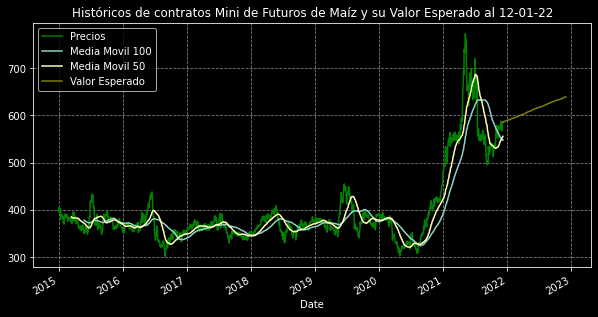

In [88]:
S0= closes_maiz.iloc[-1]
expiry = '2022-12-01'
assets_plot(closes_maiz, color='green',titulo=
            'Históricos de contratos Mini de Futuros de Maíz y su Valor Esperado al 12-01-22')

valor_esperado(S0,mu1, s1,expiry, 'olive')

El valor actual de los contratos futuros es de 585.38 por lo cual le interesaría pactar su venta a un precio igual o mayor al actual, seleccionandosé así el precio de strike de 585.
Dicho contrato, le aseguraría que de mantener su tendencia bajista, pueda vender a un precio cercano al actual y de mantenerse por encima, se beneficié de dicho aumento. En la gráfica anterior se muestra la valuación de la opción de tipo europea durante el plazo de tenencia.

Valuación de Put Europeo en Fecha Actual: 3.14
Intervalos de confianza al 95.0 %: [2.9575211849899485, 3.3144960600422984]
Valuación de Put Europeo en Fecha de ej. con Precios Simulados: 35.15
Intervalos de confianza al 95.0 %: [31.956872273117124, 38.345978762064995]


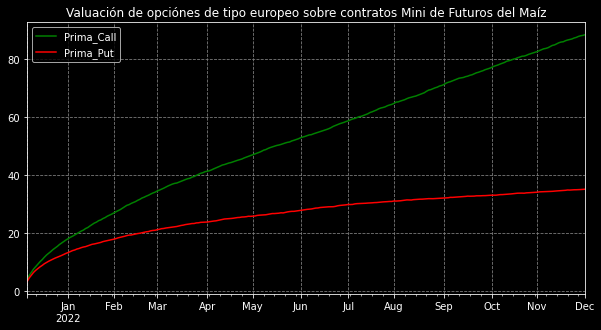

In [5]:
K1=585
Maiz_OpEu=europea(K1, S0, mu1, s1, expiry, confianza=.95, color_call='green', color_put='red',titulo=
       'Valuación de opciónes de tipo europeo sobre contratos Mini de Futuros del Maíz', C=False)

Se muestra la valuación del precio del call y del put mediante la solución de la ecuación de Black-Scholes y se aprecia que su valor se aproxima pero se mantiene por encima del límite superior de la valuación de los contratos.

Valuación de Put mediante Black-Scholes en Fecha Actual: 3.41
Valuación de Put mediante Black-Scholes en Fecha de ej.: 41.82


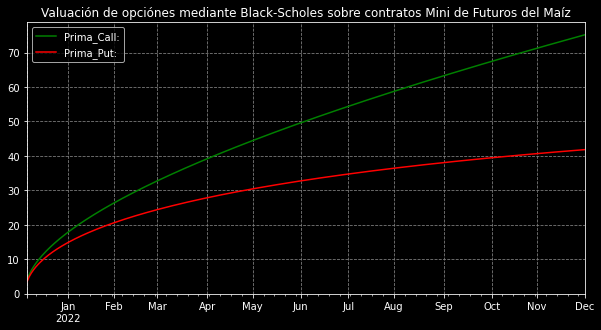

In [6]:
Maiz_OpBS=BSprices(K1,S0,mu1,s1,expiry, color_call='green', color_put='red',titulo=
        'Valuación de opciónes mediante Black-Scholes sobre contratos Mini de Futuros del Maíz', C=False)

El precio de las **primas de los calls y puts asiáticos es menor al valor de las opciones de tipo europeo**, esto es así porque conlleva un menor riesgo adquirirlas y por lo tanto **los límites de las funciones de pago tienen menos dispersión**. Esto significa que sus **posibles ganancias están limitadas**.

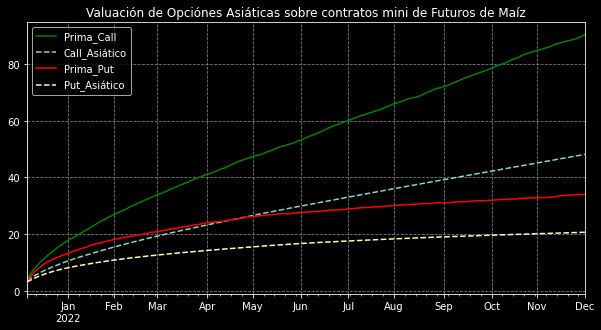

In [7]:
Maiz_OpA=asiatica(K1,S0,mu1,s1,expiry,color_call='green',color_put='red',titulo=
         'Valuación de Opciónes Asiáticas sobre contratos mini de Futuros de Maíz')

Se pueden realizar diversas estrategias con opciones barreras, algunas de las combinaciones más conocidas se muestran a continuación aunque pueden crearse muchos otros tipos de estrategias con opciones generando distintas funciones de pago cuyas primas también pueden ser simuladas. 

Para la **cobertura** en cuestión, nos es de especial interés la **prima Put Down and In** porque **no estamos especulando**, razón por la cual el **strike es cercano al precio de spot (585)** lo cual nos **cubriría ante una baja** en el precio cuya activación estaría dada por la **barrera (560)**. Por ende, los **retornos esperados** deben ser **positivos**, sin mencionar, que por dicha razón es **una de las opciones más costosas** como se puede ver, aproximándose al valor del **put de tipo europeo**.

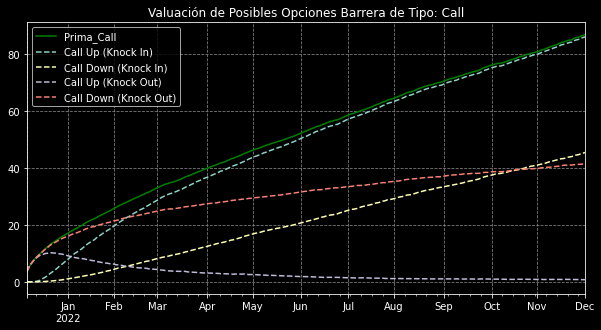

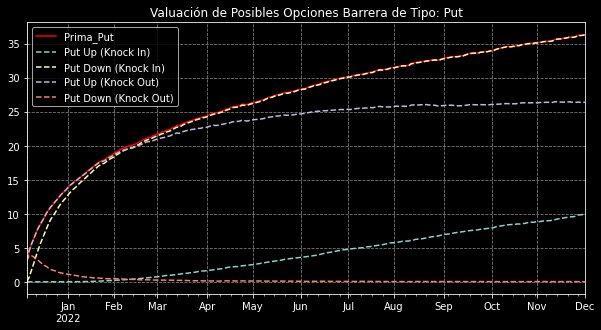

In [8]:
Maiz_OpB=barrera(K1,S0,mu1,s1,expiry,barrera_up=650,barrera_down=560, 
        color_call='green',color_put='red',titulo='Valuación de Posibles Opciones Barrera de Tipo:')

Al simular los retornos esperados verificamos que las **coberturas eliminan el riesgo del cliente a tener pérdidas**, entendiéndose por **pérdidas** a **bajas en el precio por debajo del spot**. Sin embargo, **no se consideran pérdidas** aquellos **valores terminales para el siguiente invierno menores al valor esperado** y esto es así **porque** dicha ausencia de cobertura implica consigo un **mayor riesgo** cuya posibilidad de **valores negativos** pueden apreciarse en los Retornos Esperados sin Cobertura.

De esta manera, se tiene que las funciones de pago de las coberturas son las siguientes sin considerar el valor de su prima. Desde el punto de vista del coberturista, no es posible determinar cual es mejor entre el put europeo y el put asiático porque aunque el put europeo tiene mayor dispersión hacia la alza, las Ganancias Esperadas mínimas son también menores. Esto quiere decir que le ofrece un riesgo mayor, aunque sin generarle posibles pérdidas. Considerando el valor de ambas primas, pudiera ser que un coberturista puro eligiera el Put Asiático.

El Retorno esperado sin cobertura es de: 55.21
Las Ganancias esperadas con cobertura de Put europeo es de: 55.59
El valor máx. de las Ganancias con cobertura es: 366.92
El valor min. de las Ganancias con cobertura es: 17.61


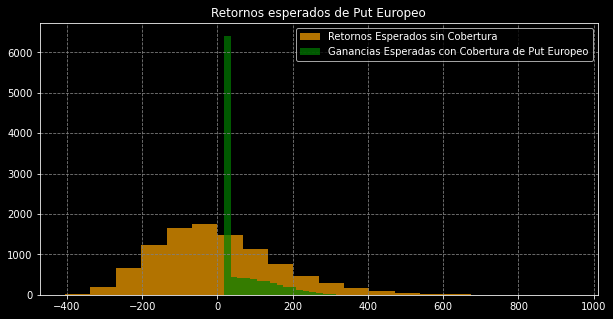

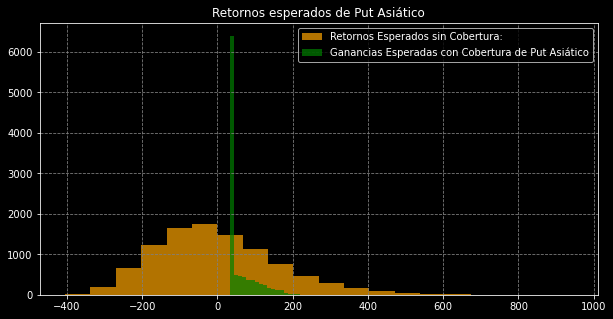

Las Ganancias esperadas con cobertura de Put asiático es de: 55.59
El valor máx. de las Ganancias con cobertura es: 252.88
El valor min. de las Ganancias con cobertura es: 32.42


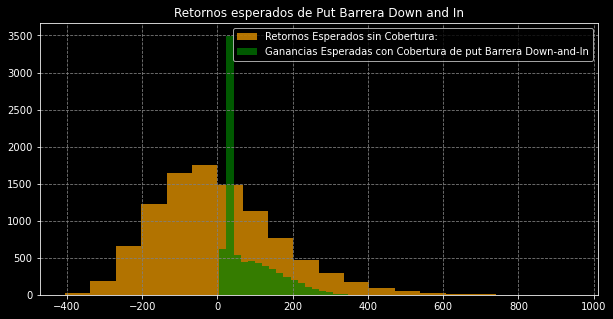

Las Ganancias esperadas con cobertura de Put Barrera Down and In es de: 78.56
El valor máx. de las Ganancias con cobertura es: 383.54
El valor min. de las Ganancias con cobertura es: 5.04


In [11]:
c1=cobertura(K1, S0, mu1, s1, expiry,C=False,bins=20, color_SC='orange', color_CC='green',barrera_down=560)

Por otro lado, tenemos que el Valor de la Barrera de Tipo Put Down and In, evidentemente tiene un valor esperado mayor aunque con ello su precio aumenta al nivel del put europeo. Por esta razón, su valor mínimo esperado es el menor aunque su valor máximo esperado es también mayor.

Sería de las 3, una opción atractiva en cuanto a retornos que satisface la cobertura solicitada.

> 2. La segunda empresa, es una empresa que construye productos en aluminio que tiene 1 año de estar ejerciendo en este tipo mercado. El gerente desea crear un plan de acción para expandir la empresa realizando estrategias financieras que le permitan maximizar sus ganancias y de esta forma cumplir con el objetivo planteado.

Para el cliente #2 asumimos los mismos supuestos que en el caso anterior y se toma como fecha de expiración un año.

In [29]:
closes_AL = get_adj_closes(['ALI=F'], '2015-01-01')
closes_AL = closes_AL.loc[:,'ALI=F']
retornos_AL = calc_daily_ret(closes_AL)
mu2,s2 = mean_std(retornos_AL)

El retorno esperado del aluminio es mucho menor al del maíz y además tuvo un claro rompimiento de tendencia que marcó una fuerte corrección cuyo fin pudiera estar aún por delante. Por esta razón, asumimos que nuestro cliente está interesado en pactar un contrato que posibilité la venta de sus productos de Aluminio a un precio dado.

El Valor Actual de los contratos de Futuros es de: 2566.75
El Valor terminal esperado de los contratos de Futuros es de: 2666.41
Un incremento porcentual esperado de: 3.88 %


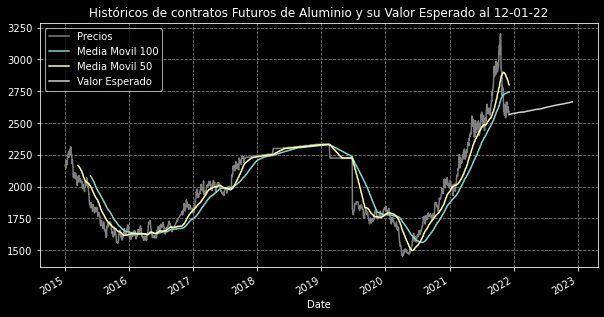

In [30]:
S02= closes_AL.iloc[-1]
expiry = '2022-12-01'
assets_plot(closes_AL, color='gray', titulo=
            'Históricos de contratos Futuros de Aluminio y su Valor Esperado al 12-01-22')

valor_esperado(S02,mu2,s2,expiry,'lightgray')

Se elige como strike 2600 porque es su resistencia más cercana, está por debajo que su precio esperado pero por encima que su precio de spot, asegurándole a nuestro cliente una venta cuyas pérdidas se límitan a la diferencia del strike y el spot menos el valor de la prima del put cuyo valor terminal esperado con su respectivo intervalo de confianza al 95% es el siguiente:.

Valuación de Put Europeo en Fecha Actual: 1.48
Intervalos de confianza al 95.0 %: [0.9257670291577104, 2.0320126205131723]
Valuación de Put Europeo en Fecha de ej. con Precios Simulados: 120.77
Intervalos de confianza al 95.0 %: [111.32035560368789, 130.22762311642978]


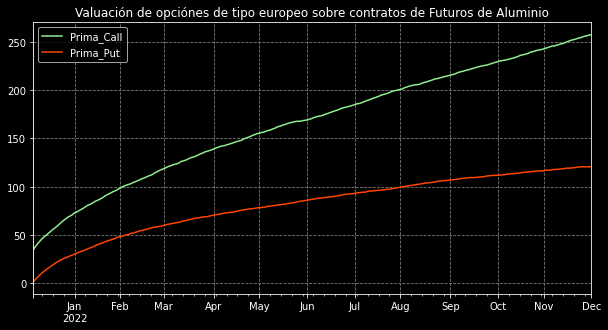

In [52]:
K2=2600
Al_OpEu=europea(S02, K2, mu2, s2, expiry, confianza=.95, color_call='lightgreen', color_put='orangered',titulo=
       'Valuación de opciónes de tipo europeo sobre contratos de Futuros de Aluminio', C=False)

A continuación se realiza la valuación mediante la solución a las ecuaciones de Black-Scholes.

Valuación de Put mediante Black-Scholes en Fecha Actual: 34.62
Valuación de Put mediante Black-Scholes en Fecha de ej.: 160.72


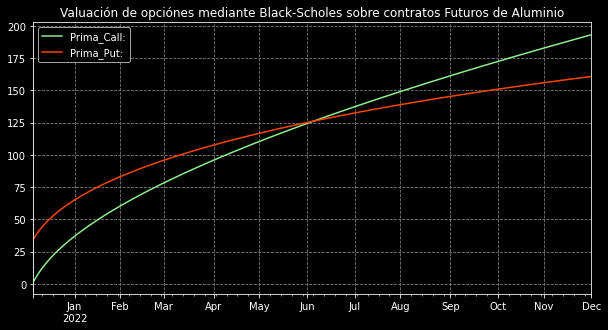

In [54]:
AL_OpBS=BSprices(K2,S02,mu2,s2,expiry, color_call='lightgreen', color_put='orangered', titulo=
        'Valuación de opciónes mediante Black-Scholes sobre contratos Futuros de Aluminio', C=False)

Las primas de las opciones asiáticas son mucho menores a las primas de tipo europeo y pudieran ser una opción atractiva debido a que nuestro cliente desea maximizar sus ganancias y no puede incurrir en riesgos que conlleven a posibles pérdidas.

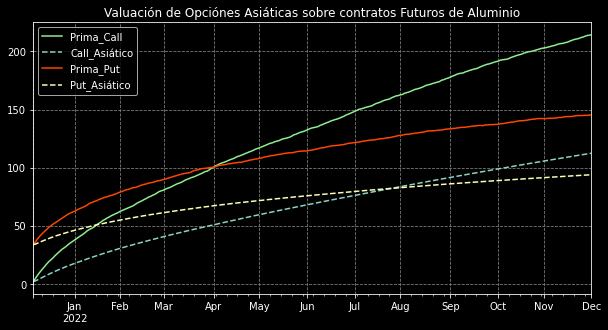

In [55]:
AL_OpA=asiatica(K2,S02,mu2,s2,expiry, color_call='lightgreen', color_put='orangered', titulo=
         'Valuación de Opciónes Asiáticas sobre contratos Futuros de Aluminio')

Las siguientes son las opciones de tipo barrera para los futuros de aluminio:

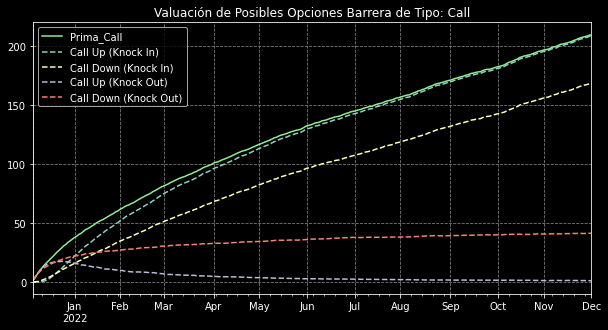

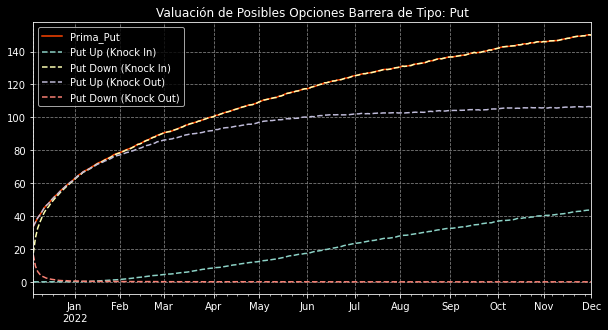

In [59]:
AL_OpB=barrera(K2,S02,mu2,s2,expiry,barrera_up=2750,barrera_down=2550, 
        color_call='lightgreen',color_put='orangered',titulo='Valuación de Posibles Opciones Barrera de Tipo:')

Asumiendo que nuestro cliente desea pactar un contrato que aseguré la venta de sus productos de Aluminio sin incurrir en pérdidas y sin afán de especular, concluimos que de las 3 coberturas propuestas aquella que le proporciona un valor esperado mayor y un menor riesgo es el Put Asiático. Por si fuera poco, su prima le será más barata como se mostró con anterioridad.


El Retorno esperado sin cobertura es de: 117.55
Las Ganancias esperadas con cobertura de Put europeo es de: 84.3
El valor máx. de las Ganancias con cobertura es: 1201.15
El valor min. de las Ganancias con cobertura es: -60.95


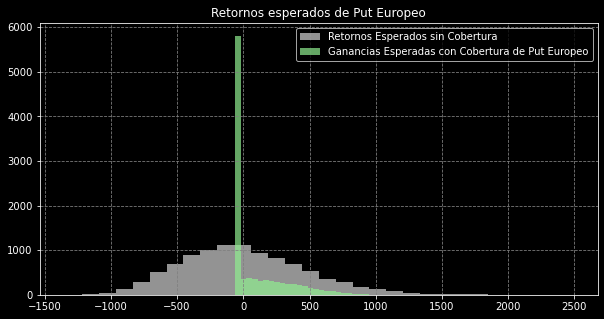

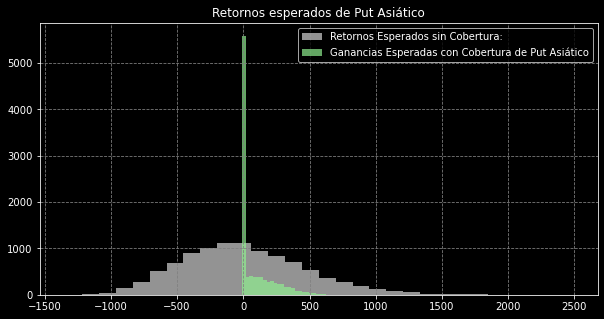

Las Ganancias esperadas con cobertura de Put asiático es de: 84.3
El valor máx. de las Ganancias con cobertura es: 785.06
El valor min. de las Ganancias con cobertura es: -8.78


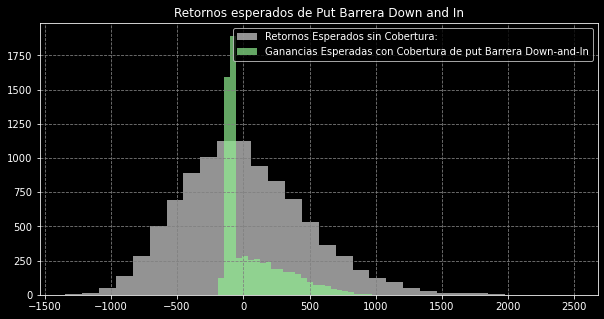

Las Ganancias esperadas con cobertura de Put Barrera Down and In es de: 56.06
El valor máx. de las Ganancias con cobertura es: 1150.77
El valor min. de las Ganancias con cobertura es: -189.18


In [58]:
c2=cobertura(K2, S02, mu2, s2, expiry,C=False,bins=30, color_SC='lightgray', color_CC='lightgreen',barrera_down=2550)

> 3. El tercer cliente, es una empresa joyera que fabrica sus piezas en oro. Esta empresa ha visto afectado sus ingresos debido a las fluctuaciones que ha presentado los últimos meses el precio del oro. Debido a esto, acude a nosotros para intentar mitigar estas fluctuaciones en el precio del oro, usando una adecuada estrategia financiera.

In [60]:
closes_G = get_adj_closes(['GC=F'], '2015-01-01')
closes_G = closes_G.loc[:,'GC=F']
retornos_G = calc_daily_ret(closes_G)
mu3,s3 = mean_std(retornos_G)

De acuerdo al valor esperado del precio de los futuros del oro los históricos apuntan a que su precio se mantenga a la alza pero su tendencia traza con claridad un canal bajista y podría ser más peligrosa su corrección para nuestro cliente si tuviera inventarios.

El Valor Actual de los contratos de Futuros es de: 1784.9
El Valor terminal esperado de los contratos de Futuros es de: 1915.54
Un incremento porcentual esperado de: 7.32 %


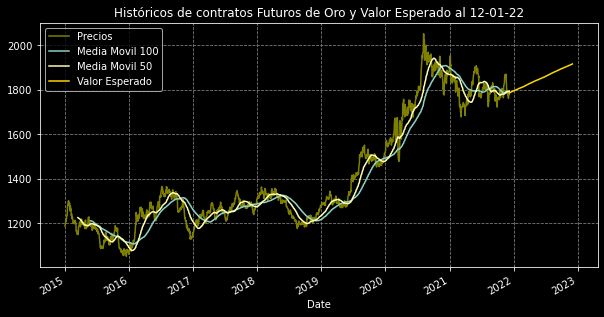

In [61]:
S03= closes_G.iloc[-1]
expiry = '2022-12-01'
assets_plot(closes_G, color='olive', titulo=
           'Históricos de contratos Futuros de Oro y Valor Esperado al 12-01-22')
valor_esperado(S03,mu3, s3,expiry, 'gold')

Por la suposición anterior se plantea una cobertura que proteja al cliente de futuras devaluaciones del oro con un strike cercano al precio de spot cuya prima no es muy costosa.

Valuación de Put Europeo en Fecha Actual: 5.79
Intervalos de confianza al 95.0 %: [5.463703480696068, 6.110028303650673]
Valuación de Put Europeo en Fecha de ej. con Precios Simulados: 54.17
Intervalos de confianza al 95.0 %: [48.44508751115681, 59.88553654021509]


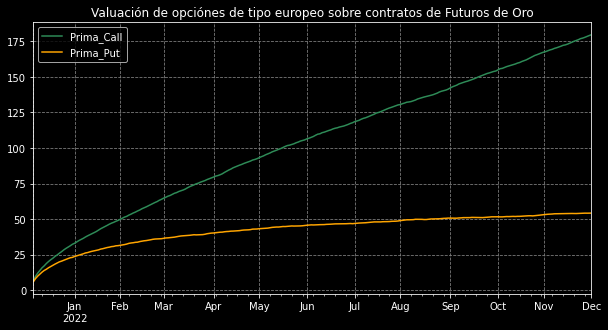

In [62]:
K3=1785
GC_OpEu=europea(S03, K3, mu3, s3, expiry, confianza=.95, color_call='seagreen', color_put='orange',titulo=
       'Valuación de opciónes de tipo europeo sobre contratos de Futuros de Oro', C=False)

Realizada la valuación mediante Black-Scholes se tiene una cálculo para el valor de la prima aproximada a la valuación anterior.

Valuación de Put mediante Black-Scholes en Fecha Actual: 6.46
Valuación de Put mediante Black-Scholes en Fecha de ej.: 58.99


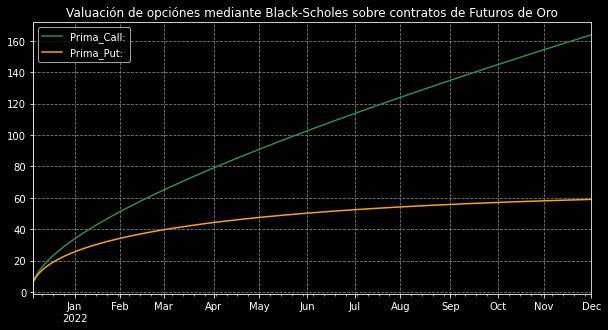

In [63]:
G_OpBS=BSprices(K3,S03,mu3,s3,expiry, color_call='seagreen', color_put='orange', titulo=
        'Valuación de opciónes mediante Black-Scholes sobre contratos de Futuros de Oro', C=False)

Se concluye de acuerdo a la prima asiática que de presentar un retorno esperado mayor o aproximado al del put europeo, se asumiría que provee una cobertura menos costosa.

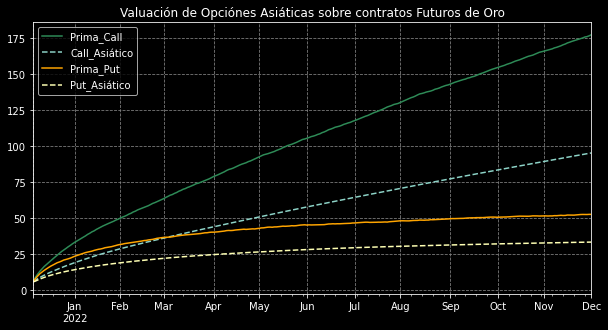

In [67]:
GC_OpA=asiatica(K3,S03,mu3,s3,expiry, color_call='seagreen', color_put='orange',titulo=
         'Valuación de Opciónes Asiáticas sobre contratos Futuros de Oro')

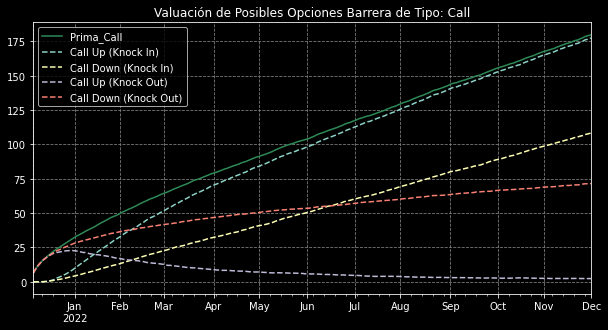

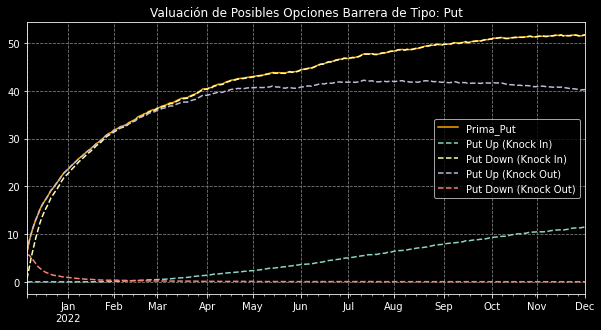

In [66]:
GC_OpB=barrera(K3,S03,mu3,s3,expiry,barrera_up=1920,barrera_down=1750, 
        color_call='seagreen',color_put='orange',titulo='Valuación de Posibles Opciones Barrera de Tipo:')

El retorno esperado sin cobertura y con cobertura es muy similar para el put asiático y europeo, más sin embargo, el valor esperado del Put Barrera Down And In es superior y sería elección de nuestro cliente si decide asumir el riesgo de un posible valor mínimo inferior y una prima más cara por un mayor valor esperado o decide ser conservador y elegir las modestas ganancias pero seguras que provee el put asiático menos su prima que es de las menos costosas.

El Retorno esperado sin cobertura es de: 133.01
Las Ganancias esperadas con cobertura de Put europeo es de: 132.91
El valor máx. de las Ganancias con cobertura es: 823.43
El valor min. de las Ganancias con cobertura es: 76.72


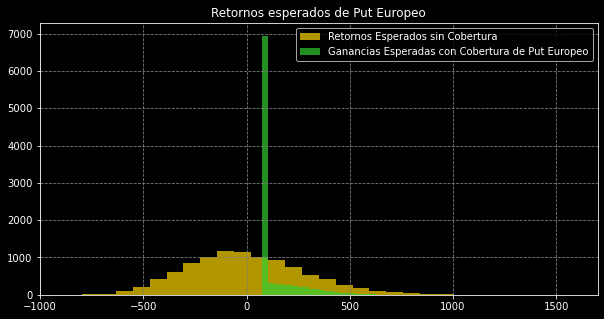

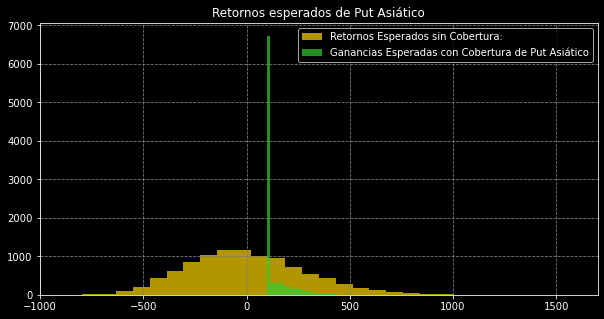

Las Ganancias esperadas con cobertura de Put asiático es de: 132.91
El valor máx. de las Ganancias con cobertura es: 518.54
El valor min. de las Ganancias con cobertura es: 97.35


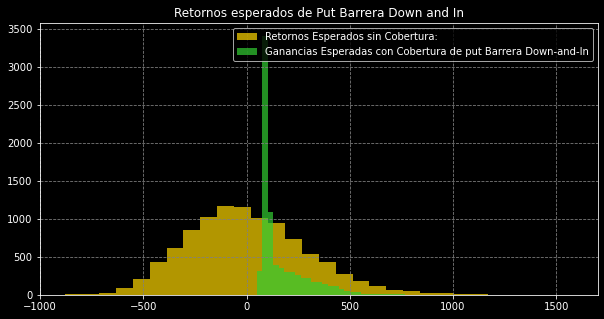

Las Ganancias esperadas con cobertura de Put Barrera Down and In es de: 164.68
El valor máx. de las Ganancias con cobertura es: 846.57
El valor min. de las Ganancias con cobertura es: 48.02


In [70]:
c3=cobertura(K3, S03, mu3, s3, expiry,C=False,bins=30, color_SC='gold', color_CC='limegreen',barrera_down=1750)

> 4. Nuestro último cliente, es la empresa mexicana PEMEX, que desea ejecutar ciertas estrategias financieras, que les permita cubrirse ante posibles caídas en el precio del barril del petróleo. Su objetivo en maximizar sus ganancias y minimizar las pérdidas de la compañía usando la mejor estrategia financiera (costo-beneficio).

In [78]:
closes_BZ = get_adj_closes(['BZ=F'], '2015-01-01')
closes_BZ = closes_BZ.loc[:,'BZ=F']
retornos_BZ = calc_daily_ret(closes_BZ)
mu4,s4 = mean_std(retornos_BZ)

El valor esperado del petróleo es el más grande de las cuatro empresas por mucho, pero esto es así por el sesgo que causó su rápida recuperación después de la fuerte caída de Covid en Marzo del 2020.
Asumiendo que PEMEX está interesado en la venta futura del petróleo, pactar un precio de strike cercano al spot para el siguiente año podría generarle ganancias a la vez que realiza su cobertura anual.

El Valor Actual de los contratos de Futuros es de: 75.16
El Valor terminal esperado de los contratos de Futuros es de: 86.54
Un incremento porcentual esperado de: 15.14 %


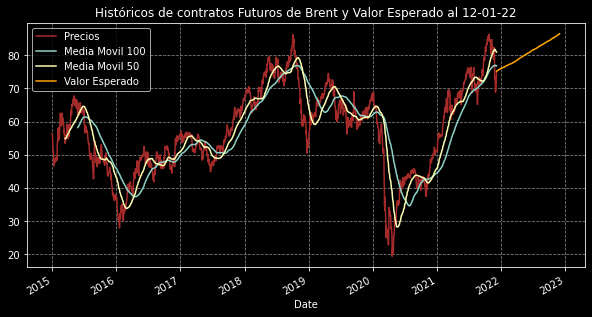

In [72]:
S04= closes_BZ.iloc[-1]
expiry = '2022-12-01'
assets_plot(closes_BZ, color='brown', titulo=
           'Históricos de contratos Futuros de Brent y Valor Esperado al 12-01-22')
valor_esperado(S04,mu4, s4,expiry, 'orange')

De acuerdo a lo anterior se elige un precio de strike de 75 para el siguiente año y se obtienen las siguientes valuaciones para los puts de tipo europeo.

Valuación de Put Europeo en Fecha Actual: 0.84
Intervalos de confianza al 95.0 %: [0.802019379642796, 0.8812857982503958]
Valuación de Put Europeo en Fecha de ej. con Precios Simulados: 8.98
Intervalos de confianza al 95.0 %: [8.187789919712545, 9.77093233009967]


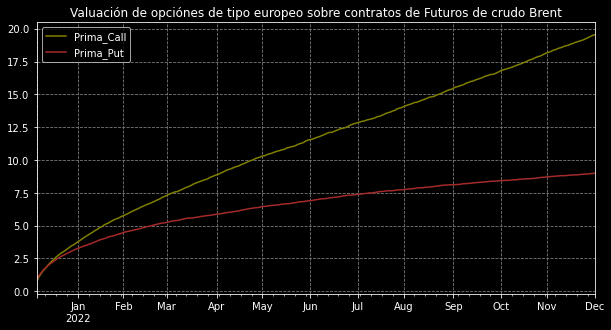

In [81]:
K4=75
BZ_OpEu=europea(S04, K4, mu4, s4, expiry, confianza=.95, color_call='olive', color_put='brown',titulo=
       'Valuación de opciónes de tipo europeo sobre contratos de Futuros de crudo Brent', C=False)

La valuación mediante Black-Scholes indica que ambas primas son más costosas, razón por la cual podría considerar pagar un precio ligeramente mayor al precio de la valuación del put de tipo europeo.

Valuación de Put mediante Black-Scholes en Fecha Actual: 0.73
Valuación de Put mediante Black-Scholes en Fecha de ej.: 11.16


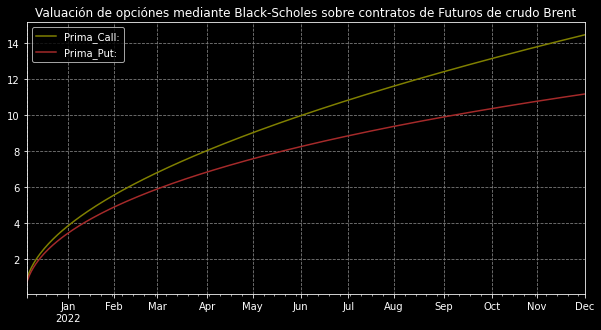

In [83]:
B_OpBS=BSprices(K4,S04,mu4,s4,expiry, color_call='olive', color_put='brown', titulo=
        'Valuación de opciónes mediante Black-Scholes sobre contratos de Futuros de crudo Brent', C=False)

Seria una estrategia bastante conservadora pagar una prima de put asiático. Y probablemente se traducirá en ganancias muy limitados en el cálculo de los retornos esperados.

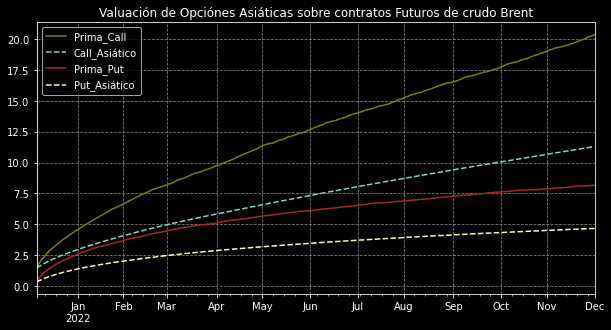

In [75]:
B_OpA=asiatica(K4,S04,mu4,s4,expiry, color_call='olive', color_put='brown', titulo=
         'Valuación de Opciónes Asiáticas sobre contratos Futuros de crudo Brent')

La simulacion de los precios de las opciones barrera es el siguiente:

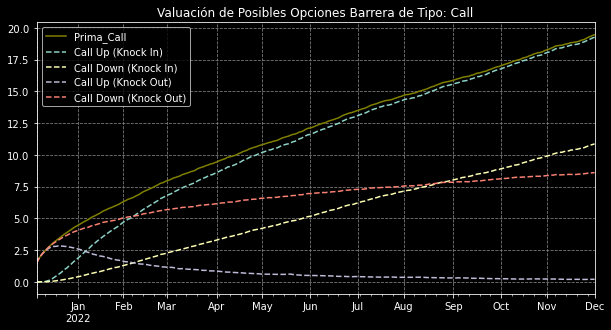

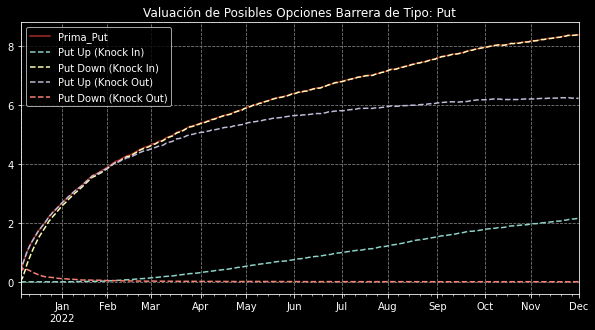

In [76]:
barrera(K4,S04,mu4,s4,expiry,barrera_up=90,barrera_down=70, 
        color_call='olive',color_put='brown',titulo='Valuación de Posibles Opciones Barrera de Tipo:')

De acuerdo a las simulaciones de las coberturas planteadas se tiene que el mayor valor esperado lo provee la opcion barrera de tipo put down and in aunque presenta posibles valores negativos. De acuerdo al valor de su prima cercano al precio del put europeo, se tiene entonces que la estrategia que proporciona el mejor costo-beneficio es la prima de tipo asiática con un valor esperado de 11.31 y prima de 4.90.

El Retorno esperado sin cobertura es de: 11.15
Las Ganancias esperadas con cobertura de Put europeo es de: 11.31
El valor máx. de las Ganancias con cobertura es: 62.88
El valor min. de las Ganancias con cobertura es: 2.22


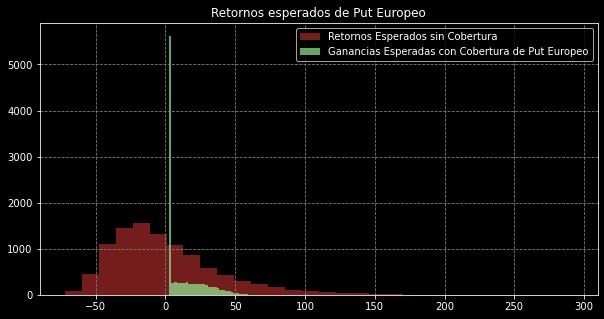

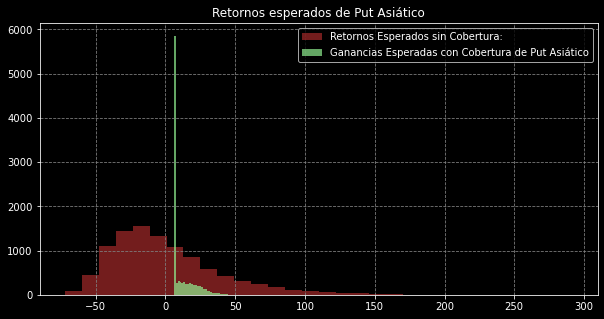

Las Ganancias esperadas con cobertura de Put asiático es de: 11.31
El valor máx. de las Ganancias con cobertura es: 47.38
El valor min. de las Ganancias con cobertura es: 5.93


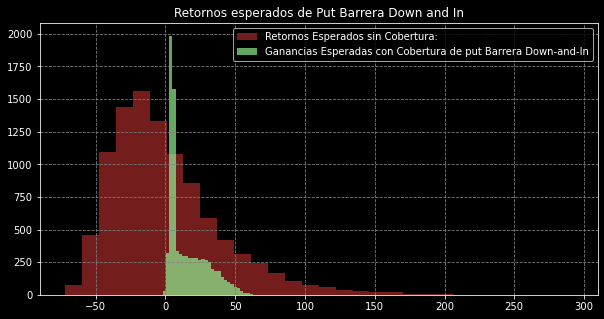

Las Ganancias esperadas con cobertura de Put Barrera Down and In es de: 15.45
El valor máx. de las Ganancias con cobertura es: 67.24
El valor min. de las Ganancias con cobertura es: -2.04


In [85]:
c4=cobertura(K4, S04, mu4, s4, expiry,C=False,bins=30, color_SC='brown', color_CC='lightgreen',barrera_down=70)

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>